# (Optional) Sentiment analysis with Vader - Notes

Similarly to the process of parallel language detection, we run the sentiment analyzer. Since it is an algorithm that runs single threaded by default, we can leverage multiple processes from ProcessPoolExecutor in python. A new function was made with the sole purpose of benchmarking, the core of the two functions is the same, but the functions are wrapped differently. The benchmark version has a bunch of measuremenets, like time and cpu usage.

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from datetime import date
import pandas as pd
import polars as pl
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import config
from paths import Paths
from src.sentiment_analysis_benchmark import get_compound_parallel_benchmark

date_obj = date.today()
channel_paths = Paths(config.channel_handle, date_obj)

## Load a small sample

In [3]:
comments_no = 200_000
comments = pl.read_parquet(channel_paths.clean_comments_file_path, columns=["comment"], n_rows=comments_no)["comment"].to_list()
print(f"Total comments: {len(comments):_}")

Total comments: 200_000


## Parallelize sentiment analysis across all processors incrementally
We are using all processors available in your machine, it is usually the number from the logical threads from your processor's specifications.
You may use a performance monitor to check for yourself how this task behaves.

We start with a single processor and finish with all available in the current machine.

In [6]:
max_workers = os.cpu_count()

results = []

for workers in range(1, max_workers + 1):
    print(f"\nBenchmarking with {workers} worker(s)...")
    workers_used, duration, throughput, avg_cpu = get_compound_parallel_benchmark(comments, workers=workers)
    efficiency = throughput / workers_used
    results.append({
        "workers": workers_used,
        "throughput": throughput,
        "efficiency": efficiency,
        "avg_cpu": avg_cpu,
        "duration": duration
    })

df = pd.DataFrame(results)


Benchmarking with 1 worker(s)...


100%|██████████| 200000/200000 [00:39<00:00, 5007.76it/s]


Sentiment scores collection finished in 39.97s, 5004.31 c/s
Average CPU Usage: 13.94%

Benchmarking with 2 worker(s)...


100%|██████████| 200000/200000 [00:21<00:00, 9194.50it/s] 


Sentiment scores collection finished in 21.76s, 9192.81 c/s
Average CPU Usage: 23.87%

Benchmarking with 3 worker(s)...


100%|██████████| 200000/200000 [00:16<00:00, 11774.98it/s]


Sentiment scores collection finished in 16.99s, 11773.60 c/s
Average CPU Usage: 31.18%

Benchmarking with 4 worker(s)...


100%|██████████| 200000/200000 [00:14<00:00, 13798.45it/s]


Sentiment scores collection finished in 14.50s, 13794.64 c/s
Average CPU Usage: 39.46%

Benchmarking with 5 worker(s)...


100%|██████████| 200000/200000 [00:11<00:00, 16825.86it/s]


Sentiment scores collection finished in 11.89s, 16820.90 c/s
Average CPU Usage: 39.78%

Benchmarking with 6 worker(s)...


100%|██████████| 200000/200000 [00:11<00:00, 17473.61it/s]


Sentiment scores collection finished in 11.45s, 17467.51 c/s
Average CPU Usage: 43.04%

Benchmarking with 7 worker(s)...


100%|██████████| 200000/200000 [00:10<00:00, 18874.12it/s]


Sentiment scores collection finished in 10.60s, 18868.25 c/s
Average CPU Usage: 49.60%

Benchmarking with 8 worker(s)...


100%|██████████| 200000/200000 [00:10<00:00, 19115.70it/s]


Sentiment scores collection finished in 10.47s, 19110.21 c/s
Average CPU Usage: 57.02%

Benchmarking with 9 worker(s)...


100%|██████████| 200000/200000 [00:10<00:00, 19218.96it/s]


Sentiment scores collection finished in 10.41s, 19215.27 c/s
Average CPU Usage: 61.61%

Benchmarking with 10 worker(s)...


100%|██████████| 200000/200000 [00:10<00:00, 19739.24it/s]


Sentiment scores collection finished in 10.14s, 19730.45 c/s
Average CPU Usage: 66.83%

Benchmarking with 11 worker(s)...


100%|██████████| 200000/200000 [00:10<00:00, 19762.40it/s]


Sentiment scores collection finished in 10.13s, 19751.63 c/s
Average CPU Usage: 70.00%

Benchmarking with 12 worker(s)...


100%|██████████| 200000/200000 [00:09<00:00, 20492.44it/s]


Sentiment scores collection finished in 9.77s, 20479.84 c/s
Average CPU Usage: 69.18%


This time we saved the progress to a dataframe

In [17]:
df["single_core_perf"] = df["throughput"] / df["workers"]
baseline = df["single_core_perf"].iloc[0]
df["single_core_perf_pct"] = df["single_core_perf"].apply(lambda x: 100 * x / baseline)

### Visualizing multi processor performance for sentiment analysis

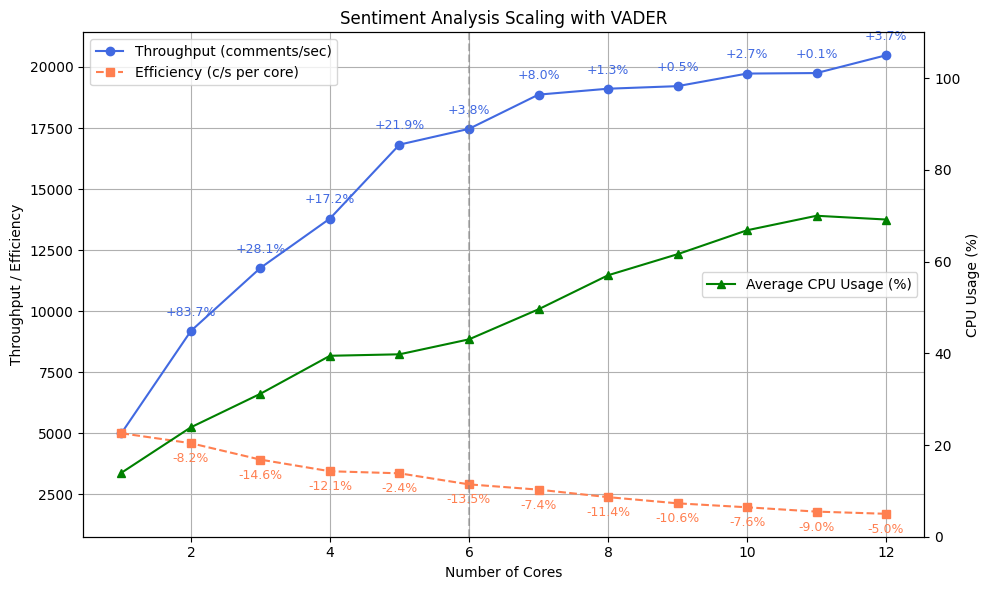

In [28]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot throughput (blue)
ax1.plot(df["workers"], df["throughput"], marker='o', color='royalblue', label="Throughput (comments/sec)")

# Add % increase tags for throughput
for i in range(1, len(df)):
    prev = df["throughput"].iloc[i - 1]
    curr = df["throughput"].iloc[i]
    pct_increase = (curr - prev) / prev * 100
    ax1.text(
        df["workers"].iloc[i],
        df["throughput"].iloc[i] + 500,
        f"+{pct_increase:.1f}%",
        ha='center',
        va='bottom',
        fontsize=9,
        color='royalblue'
    )

# Plot efficiency (orange)
ax1.plot(df["workers"], df["efficiency"], marker='s', linestyle='--', color='coral', label="Efficiency (c/s per core)")

# Add % change tags for efficiency
for i in range(1, len(df)):
    prev_eff = df["efficiency"].iloc[i - 1]
    curr_eff = df["efficiency"].iloc[i]
    pct_change_eff = (curr_eff - prev_eff) / prev_eff * 100
    ax1.text(
        df["workers"].iloc[i],
        df["efficiency"].iloc[i] - 900,
        f"{pct_change_eff:+.1f}%",
        ha='center',
        va='bottom',
        fontsize=9,
        color='coral'
    )

ax1.set_xlabel("Number of Cores")
ax1.set_ylabel("Throughput / Efficiency")
ax1.legend(loc="upper left")
ax1.grid(True)

# Vertical line at physical cores
physical_cores = os.cpu_count() // 2
ax1.axvline(x=physical_cores, color='gray', linestyle='--', alpha=0.5)

# Secondary y-axis for CPU usage
ax2 = ax1.twinx()
ax2.plot(df["workers"], df["avg_cpu"], marker='^', color='green', label="Average CPU Usage (%)")
ax2.set_ylabel("CPU Usage (%)")
ax2.set_ylim(0, 110)
ax2.legend(loc="center right")

plt.title(f"Sentiment Analysis Scaling with VADER")
plt.tight_layout()
plt.show()
